In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import cvxpy as cp

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import time

### kinematics model equations

The variables of the model are:

* $x$ coordinate of the robot
* $y$ coordinate of the robot
* $\theta$ heading of the robot
* $\psi$ heading error = $\psi = \theta_{ref} - \theta$
* $cte$ crosstrack error = lateral distance of the robot from the path 

The inputs of the model are:

* $v$ linear velocity of the robot
* $w$ angular velocity of the robot

These are the differential equations f(x,u) of the model:

* $\dot{x} = v\cos{\theta}$ 
* $\dot{y} = v\sin{\theta}$
* $\dot{\theta} = w$
* $\dot{\psi} = -w$
* $\dot{cte} = v\sin{-\psi}$

The **Continuous** State Space Model is

$ {\dot{x}} = Ax + Bu $

with:

$ A =
\quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial x} & \frac{\partial f(x,u)}{\partial y} & \frac{\partial f(x,u)}{\partial \theta} & \frac{\partial f(x,u)}{\partial \psi} & \frac{\partial f(x,u)}{\partial cte} \\
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
0 & 0 & -vsin(\theta) & 0 & 0 \\
0 & 0 & vcos(\theta) & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -vcos(-\psi) & 0 
\end{bmatrix}
\quad $


$ B = \quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial v} & \frac{\partial f(x,u)}{\partial w} \\
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos{\theta_t} & 0 \\
\sin{\theta_t} & 0 \\
0 & 1 \\
0 & -1 \\
-\sin{(-\psi_t)} & 0  
\end{bmatrix}
\quad $

discretize with forward Euler Integration for time step dt:

* ${x_{t+1}} = x_{t} + v_t\cos{\theta}*dt$
* ${y_{t+1}} = y_{t} + v_t\sin{\theta}*dt$
* ${\theta_{t+1}} = \theta_{t} + w_t*dt$
* ${\psi_{t+1}} = \psi_{t} - w_t*dt$
* ${cte_{t+1}} = cte_{t} + v_t\sin{-\psi}*dt$

The **Discrete** State Space Model is then:

${x_{t+1}} = Ax_t + Bu_t $

with:

$
A = \quad
\begin{bmatrix}
1 & 0 & -v\sin{\theta}dt & 0 & 0 \\
0 & 1 & v\cos{\theta}dt & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & -vcos{(-\psi)}dt & 1 
\end{bmatrix}
\quad
$

$
B = \quad
\begin{bmatrix}
\cos{\theta_t}dt & 0 \\
\sin{\theta_t}dt & 0 \\
0 & dt \\
0 & -dt \\
-\sin{-\psi_t}dt & 0  
\end{bmatrix}
\quad
$

This State Space Model is **non-linear** (A,B are time changing), to linearize it the **Taylor's series expansion** is used around $\bar{x}$ and $\bar{u}$:

$ \dot{x} = f(x,u) \approx f(\bar{x},\bar{u}) +  A(x-\bar{x}) + B(u-\bar{u})$

So:

$ x_{t+1} = x_t + (f(\bar{x},\bar{u}) +  A(x_t-\bar{x}) + B(u_t-\bar{u}) )dt $

$ x_{t+1} = (I+dtA)x_t + dtBu_t +dt(f(\bar{x},\bar{u}) - A\bar{x} - B\bar{u}))$

The Discrete linearized kinematics model is

$ x_{t+1} = A'x_t + B' u_t + C' $

with:

$ A' = I+dtA $

$ B' = dtB $

$ C' = dt(f(\bar{x},\bar{u}) - A\bar{x} - B\bar{u}) $

------------------
NB: psi and cte are expressed w.r.t. the track as reference frame.
In the reference frame of the veicle the equtions would be:
* psi_dot = w
* cte_dot = sin(psi)
-----------------

-----------------
[About Taylor Series Expansion](https://courses.engr.illinois.edu/ece486/fa2017/documents/lecture_notes/state_space_p2.pdf):

In order to linearize general nonlinear systems, we will use the Taylor Series expansion of functions.

Typically it is possible to assume that the system is operating about some nominal
state solution $\bar{x}$ (possibly requires a nominal input $\bar{u}$) called **equilibrium point**.

Recall that the Taylor Series expansion of f(x) around the
point $\bar{x}$ is given by:

$f(x)=f(\bar{x}) + \frac{df(x)}{dx}|_{x=\bar{x}}(x-\bar{x})$ + higher order terms...

For x sufficiently close to $\bar{x}$, these higher order terms will be very close to zero, and so we can drop them.

The extension to functions of multiple states and inputs is very similar to the above procedure.Suppose the evolution of state x
is given by:

$\dot{x} = f(x1, x2, . . . , xn, u1, u2, . . . , um) = Ax+Bu$

Where:

$ A =
\quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial x1} & ... & \frac{\partial f(x,u)}{\partial xn} \\
\end{bmatrix}
\quad
$ and $ B = \quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial u1} & ... & \frac{\partial f(x,u)}{\partial um} \\
\end{bmatrix}
\quad $

Then:

$f(x,u)=f(\bar{x},\bar{u}) + \frac{df(x,u)}{dx}|_{x=\bar{x}}(x-\bar{x}) + \frac{df(x,u)}{du}|_{u=\bar{u}}(u-\bar{u}) = f(\bar{x},\bar{u}) + A_{x=\bar{x}}(x-\bar{x}) + B_{u=\bar{u}}(u-\bar{u})$

-----------------

### Kinematics Model

In [2]:
# Control problem statement.

N = 5 #number of state variables
M = 2 #number of control variables
T = 20 #Prediction Horizon
dt = 0.25 #discretization step

x = cp.Variable((N, T+1))
u = cp.Variable((M, T))

In [3]:
def get_linear_model(x_bar,u_bar):
    """
    """
    
    x = x_bar[0]
    y = x_bar[1]
    theta = x_bar[2]
    psi = x_bar[3]
    cte = x_bar[4]
    
    v = u_bar[0]
    w = u_bar[1]
    
    A = np.zeros((N,N))
    A[0,2]=-v*np.sin(theta)
    A[1,2]=v*np.cos(theta)
    A[4,3]=-v*np.cos(-psi)
    A_lin=np.eye(N)+dt*A
    
    B = np.zeros((N,M))
    B[0,0]=np.cos(theta)
    B[1,0]=np.sin(theta)
    B[2,1]=1
    B[3,1]=-1
    B[4,0]=-np.sin(-psi)
    B_lin=dt*B
    
    f_xu=np.array([v*np.cos(theta),v*np.sin(theta),w,-w,v*np.sin(-psi)]).reshape(N,1)
    C_lin = dt*(f_xu - np.dot(A,x_bar.reshape(N,1)) - np.dot(B,u_bar.reshape(M,1)))
    
    return A_lin,B_lin,C_lin

Motion Prediction: using scipy intergration

In [4]:
# Define process model
def kinematics_model(x,t,u):
    """
    """

    dxdt = u[0]*np.cos(x[2])
    dydt = u[0]*np.sin(x[2])
    dthetadt = u[1]
    dpsidt = -u[1]
    dctedt = u[0]*np.sin(-x[3])

    dqdt = [dxdt,
            dydt,
            dthetadt,
            dpsidt,
            dctedt]

    return dqdt

def predict(x0,u):
    """
    """
    
    x_bar = np.zeros((N,T+1))
    
    x_bar[:,0] = x0
    
    # solve ODE
    for t in range(1,T+1):

        tspan = [0,dt]
        x_next = odeint(kinematics_model,
                         x0,
                         tspan,
                         args=(u[:,t-1],))

        x0 = x_next[1]
        x_bar[:,t]=x_next[1]
        
    return x_bar

Validate the model, here the status w.r.t a straight line with constant heading 0

In [5]:
%%time

u_bar = np.zeros((M,T))
u_bar[0,:] = 1 #m/s
u_bar[1,:] = np.radians(-10) #rad/s

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = np.radians(0)
x0[3] = 0
x0[4] = 1

x_bar=predict(x0,u_bar)

CPU times: user 4.59 ms, sys: 294 µs, total: 4.89 ms
Wall time: 4.68 ms


Check the model prediction

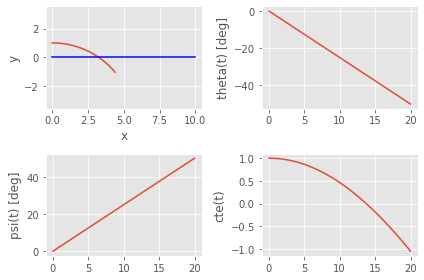

In [6]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(np.linspace(0,10,T+1),np.zeros(T+1),"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(np.degrees(x_bar[2,:]))
plt.ylabel('theta(t) [deg]')
#plt.xlabel('time')

plt.subplot(2, 2, 3)
plt.plot(np.degrees(x_bar[3,:]))
plt.ylabel('psi(t) [deg]')
#plt.xlabel('time')

plt.subplot(2, 2, 4)
plt.plot(x_bar[4,:])
plt.ylabel('cte(t)')

plt.tight_layout()
plt.show()

the results seems valid:
* the cte is correct
* theta error is correct

Motion Prediction: using the state space model

In [7]:
%%time

u_bar = np.zeros((M,T))
u_bar[0,:] = 1 #m/s
u_bar[1,:] = np.radians(-10) #rad/s

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = np.radians(0)
x0[3] = 0
x0[4] = 1

x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t-1].reshape(5,1)
    ut=u_bar[:,t-1].reshape(2,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.dot(A,xt)+np.dot(B,ut)+C
    
    x_bar[:,t]= np.squeeze(xt_plus_one)

CPU times: user 4.24 ms, sys: 0 ns, total: 4.24 ms
Wall time: 4.74 ms


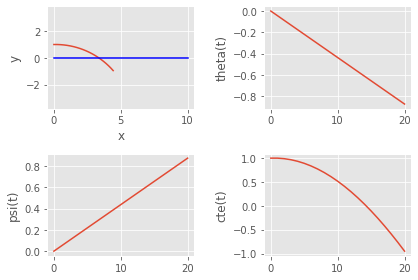

In [8]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(np.linspace(0,10,T+1),np.zeros(T+1),"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(x_bar[2,:])
plt.ylabel('theta(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 3)
plt.plot(x_bar[3,:])
plt.ylabel('psi(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 4)
plt.plot(x_bar[4,:])
plt.ylabel('cte(t)')

plt.tight_layout()
plt.show()

The results are the same as expected

------------------

the kinematics model predictits psi and cte for constant heading references. So, for non-constant paths appropriate functions have to be developed.

-----------------

In [9]:
def calc_err(state,path):
    """
    Finds psi and cte w.r.t. the closest waypoint.

    :param state: array_like, state of the vehicle [x_pos, y_pos, theta]
    :param path: array_like, reference path ((x1, x2, ...), (y1, y2, ...), (th1 ,th2, ...)]
    :returns: (float,float)
    """

    dx = state[0]-path[0,:]
    dy = state[1]-path[1,:]
    dist = np.sqrt(dx**2 + dy**2)
    nn_idx = np.argmin(dist)

    try:
        v = [path[0,nn_idx+1] - path[0,nn_idx],
             path[1,nn_idx+1] - path[1,nn_idx]]   
        v /= np.linalg.norm(v)

        d = [path[0,nn_idx] - state[0],
             path[1,nn_idx] - state[1]]

        if np.dot(d,v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx+1

    except IndexError as e:
        target_idx = nn_idx

#     front_axle_vect = [np.cos(state[2] - np.pi / 2),
#                        np.sin(state[2] - np.pi / 2)]
    path_ref_vect = [np.cos(path[2,target_idx] + np.pi / 2),
                     np.sin(path[2,target_idx] + np.pi / 2)]
    
    #heading error w.r.t path frame
    psi = path[2,target_idx] - state[2]
    #psi = -path[2,target_idx] + state[2]
        
    # the cross-track error is given by the scalar projection of the car->wp vector onto the faxle versor
    #cte = np.dot([dx[target_idx], dy[target_idx]],front_axle_vect)
    cte = np.dot([dx[target_idx], dy[target_idx]],path_ref_vect)

    return target_idx,psi,cte

def compute_path_from_wp(start_xp, start_yp, step = 0.1):
    """
    Interpolation range is computed to assure one point every fixed distance step [m].
    
    :param start_xp: array_like, list of starting x coordinates
    :param start_yp: array_like, list of starting y coordinates
    :param step: float, interpolation distance [m] between consecutive waypoints
    :returns: array_like, of shape (3,N)
    """

    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,int(section_len/delta))
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        final_xp=np.append(final_xp,fx(interp_range))
        final_yp=np.append(final_yp,fy(interp_range))
        
    dx = np.append(0, np.diff(final_xp))
    dy = np.append(0, np.diff(final_yp))
    theta = np.arctan2(dy, dx)

    return np.vstack((final_xp,final_yp,theta))

test it

In [10]:
track = compute_path_from_wp([0,5],[0,0])

u_bar = np.zeros((M,T))
u_bar[0,:] = 1 #m/s
u_bar[1,:] = np.radians(-10) #rad/s

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = np.radians(0)
_,psi,cte = calc_err(x0,track)
x0[3]=psi
x0[4]=cte

x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t-1].reshape(5,1)
    ut=u_bar[:,t-1].reshape(2,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
    
    _,psi,cte = calc_err(xt_plus_one,track)
    xt_plus_one[3]=psi
    xt_plus_one[4]=cte
    
    x_bar[:,t]= xt_plus_one

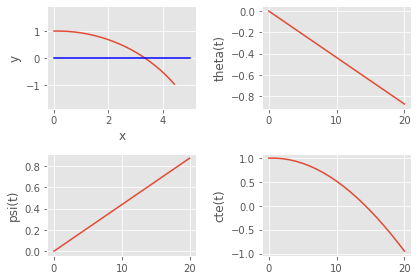

In [11]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(track[0,:],track[1,:],"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(x_bar[2,:])
plt.ylabel('theta(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 3)
plt.plot(x_bar[3,:])
plt.ylabel('psi(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 4)
plt.plot(x_bar[4,:])
plt.ylabel('cte(t)')

plt.tight_layout()
plt.show()

In [12]:
track = compute_path_from_wp([0,2,4,5,10],[0,0,3,1,1])

u_bar = np.zeros((M,T))
u_bar[0,:] = 1 #m/s
u_bar[1,:] = np.radians(10) #rad/s

x0 = np.zeros(N)
x0[0] = 2
x0[1] = 2
x0[2] = np.radians(0)
_,psi,cte = calc_err(x0,track)
x0[3]=psi
x0[4]=cte

x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t-1].reshape(5,1)
    ut=u_bar[:,t-1].reshape(2,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
    
    _,psi,cte = calc_err(xt_plus_one,track)
    xt_plus_one[3]=psi
    xt_plus_one[4]=cte
    
    x_bar[:,t]= xt_plus_one

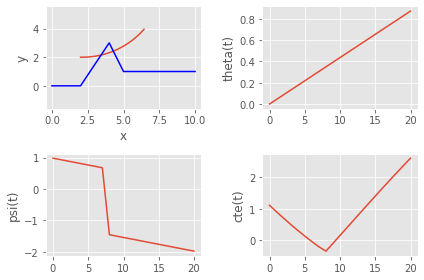

In [13]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(track[0,:],track[1,:],"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(x_bar[2,:])
plt.ylabel('theta(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 3)
plt.plot(x_bar[3,:])
plt.ylabel('psi(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 4)
plt.plot(x_bar[4,:])
plt.ylabel('cte(t)')

plt.tight_layout()
plt.show()

### MPC Problem formulation

**Model Predictive Control** refers to the control approach of **numerically** solving a optimization problem at each time step. 

The controller generates a control signal over a fixed lenght T (Horizon) at each time step.

![mpc](img/mpc_block_diagram.png)

![mpc](img/mpc_t.png)

#### Linear MPC Formulation

Linear MPC makes use of the **LTI** (Linear time invariant) discrete state space model, wich represents a motion model used for Prediction.

$x_{t+1} = Ax_t + Bu_t$

The LTI formulation means that **future states** are linearly related to the current state and actuator signal. Hence, the MPC seeks to find a **control policy** U over a finite lenght horizon.

$U={u_{t|t}, u_{t+1|t}, ...,u_{t+T|t}}$

The objective function used minimize (drive the state to 0) is:

$
\begin{equation}
\begin{aligned}
\min_{} \quad &  \sum^{t+T-1}_{j=t} x^T_{j|t}Qx_{j|t} + u^T_{j|t}Ru_{j|t}\\
\textrm{s.t.} \quad &  x(0) = x0\\
  & x_{j+1|t} = Ax_{j|t}+Bu_{j|t}) \quad  \textrm{for} \quad t<j<t+T-1    \\
\end{aligned}
\end{equation}
$

Other linear constrains may be applied,for instance on the control variable:

$ U_{MIN} < u_{j|t} < U_{MAX}    \quad  \textrm{for} \quad t<j<t+T-1 $

The objective fuction accounts for quadratic error on deviation from 0 of the state and the control inputs sequences. Q and R are the **weight matrices** and are used to tune the response.

Because the goal is tracking a **reference signal** such as a trajectory, the objective function is rewritten as:

$
\begin{equation}
\begin{aligned}
\min_{} \quad &  \sum^{t+T-1}_{j=t} \delta x^T_{j|t}Q\delta x_{j|t} + u^T_{j|t}Ru_{j|t}
\end{aligned}
\end{equation}
$

where the error w.r.t desired state is accounted for:

$ \delta x = x_{j,t,ref} - x_{j,t} $

#### Non-Linear MPC Formulation

In general cases, the objective function is any non-differentiable non-linear function of states and inputs over a finite horizon T. In this case the constrains include nonlinear dynamics of motion.

$
\begin{equation}
\begin{aligned}
\min_{} \quad &  \sum^{t+T}_{j=t} C(x_{j|t},{j|t})\\
\textrm{s.t.} \quad &  x(0) = x0\\
  & x_{j+1|t} = f(x_{j|t},u_{j|t}) \quad  \textrm{for} \quad t<j<t+T-1    \\
\end{aligned}
\end{equation}
$

Other nonlinear constrains may be applied:

$ g(x_{j|t},{j|t})<0 \quad  \textrm{for} \quad t<j<t+T-1 $

In [17]:
%%time

track = compute_path_from_wp([0,10],[0,0])

MAX_SPEED = 2.5
MIN_SPEED = 0.5
MAX_STEER_SPEED = 1.57/2

#starting guess
u_bar = np.zeros((M,T))
u_bar[0,:]=0.5*(MAX_SPEED+MIN_SPEED)
u_bar[1,:]=0.01

# Starting Condition
x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = np.radians(-0)
_,psi,cte = calc_err(x0,track)
x0[3]=psi
x0[4]=cte

# Linearized Model Prediction
x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t].reshape(5,1)
    ut=u_bar[:,t-1].reshape(2,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
    
    _,psi,cte = calc_err(xt_plus_one,track)
    xt_plus_one[3]=psi
    xt_plus_one[4]=cte
    x_bar[:,t]= xt_plus_one


#CVXPY Linear MPC problem statement
cost = 0
constr = []

for t in range(T):
    
    # Tracking
    if t > 0:
        idx,_,_ = calc_err(x_bar[:,t],track)
        delta_x = track[:,idx]-x[0:3,t]
        cost+= cp.quad_form(delta_x,10*np.eye(3))

    # Tracking last time step
    if t == T:
        idx,_,_ = calc_err(x_bar[:,t],track)
        delta_x = track[:,idx]-x[0:3,t]
        cost+= cp.quad_form(delta_x,100*np.eye(3))

    # Actuation rate of change
    if t < (T - 1):
        cost += cp.quad_form(u[:, t + 1] - u[:, t], 25*np.eye(M))
    
    #constrains
    A,B,C=get_linear_model(x_bar[:,t],u_bar[:,t])
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t] + C.flatten()]
    
# sums problem objectives and concatenates constraints.
constr += [x[:,0] == x0]
constr += [u[0, :] <= MAX_SPEED]
constr += [u[0, :] >= MIN_SPEED]
constr += [cp.abs(u[1, :]) <= MAX_STEER_SPEED]


prob = cp.Problem(cp.Minimize(cost), constr)
solution = prob.solve(solver=cp.OSQP, verbose=False)

CPU times: user 109 ms, sys: 81 µs, total: 109 ms
Wall time: 108 ms


Print Results:

No handles with labels found to put in legend.


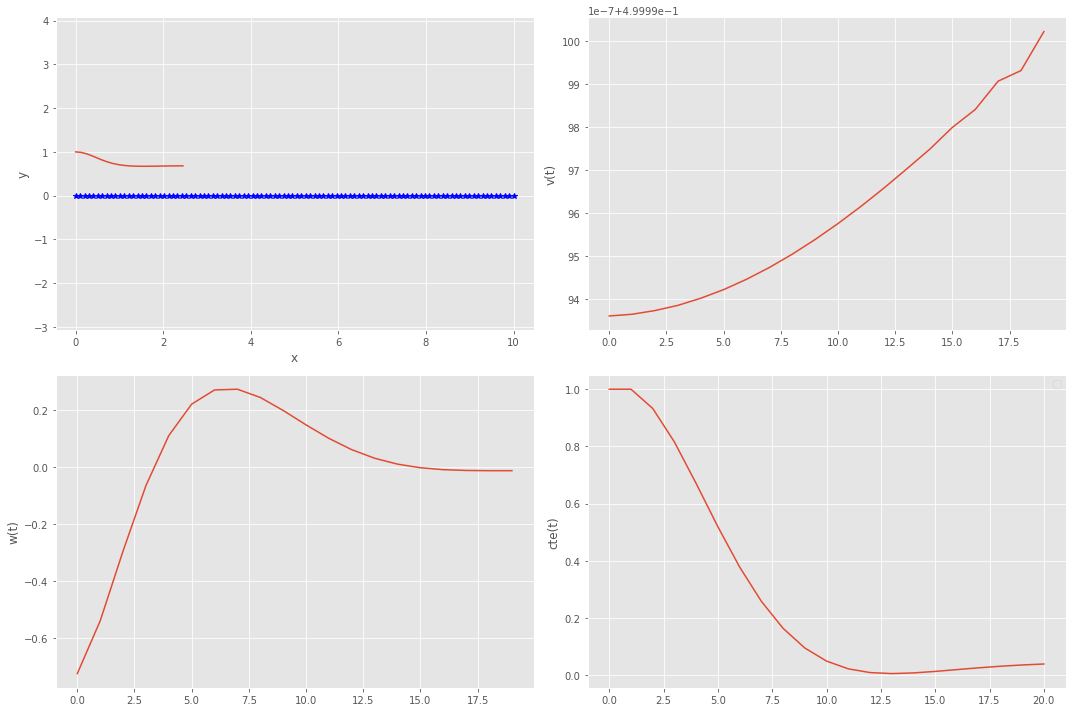

In [18]:
x_mpc=np.array(x.value[0, :]).flatten()
y_mpc=np.array(x.value[1, :]).flatten()
theta_mpc=np.array(x.value[2, :]).flatten()
psi_mpc=np.array(x.value[3, :]).flatten()
cte_mpc=np.array(x.value[4, :]).flatten()
v_mpc=np.array(u.value[0, :]).flatten()
w_mpc=np.array(u.value[1, :]).flatten()

#simulate robot state trajectory for optimized U
x_traj=predict(x0, np.vstack((v_mpc,w_mpc)))
plt.figure(figsize=(15,10))
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(track[0,:],track[1,:],"b*")
plt.plot(x_traj[0,:],x_traj[1,:])
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

#plot v(t)
plt.subplot(2, 2, 2)
plt.plot(v_mpc)
plt.ylabel('v(t)')
#plt.xlabel('time')

#plot w(t)
plt.subplot(2, 2, 3)
plt.plot(w_mpc)
plt.ylabel('w(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 4)
plt.plot(cte_mpc)
plt.ylabel('cte(t)')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

full track demo

In [19]:

track = compute_path_from_wp([0,5,7.5,10,12,13,13,10],
                             [0,0,2.5,2.5,0,0,5,10])

sim_duration =100 
opt_time=[]

x_sim = np.zeros((N,sim_duration))
u_sim = np.zeros((M,sim_duration-1))

MAX_SPEED = 1.25
MIN_SPEED = 0.75
MAX_STEER_SPEED = 1.57/2

# Starting Condition
x0 = np.zeros(N)
x0[0] = 0
x0[1] = -0.5
x0[2] = np.radians(-0)
_,psi,cte = calc_err(x0,track)
x0[3]=psi
x0[4]=cte

x_sim[:,0]=x0
                 
#starting guess
u_bar = np.zeros((M,T))
u_bar[0,:]=0.5*(MAX_SPEED+MIN_SPEED)
u_bar[1,:]=0.01

for sim_time in range(sim_duration-1):
    
    iter_start=time.time()
    
    # Prediction
    x_bar=np.zeros((N,T+1))
    x_bar[:,0]=x_sim[:,sim_time]

    for t in range (1,T+1):
        xt=x_bar[:,t-1].reshape(5,1)
        ut=u_bar[:,t-1].reshape(2,1)

        A,B,C=get_linear_model(xt,ut)

        xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)

        _,psi,cte = calc_err(xt_plus_one,track)
        xt_plus_one[3]=psi
        xt_plus_one[4]=cte

        x_bar[:,t]= xt_plus_one


    #CVXPY Linear MPC problem statement
    cost = 0
    constr = []

    for t in range(T):

        # Tracking
        if t > 0:
            idx,_,_ = calc_err(x_bar[:,t],track)
            delta_x = track[:,idx]-x[0:3,t]
            cost+= cp.quad_form(delta_x,10*np.eye(3))
            
        # Tracking last time step
        if t == T:
            idx,_,_ = calc_err(x_bar[:,t],track)
            delta_x = track[:,idx]-x[0:3,t]
            cost+= cp.quad_form(delta_x,100*np.eye(3))

        # Actuation rate of change
        if t < (T - 1):
            cost += cp.quad_form(u[:, t + 1] - u[:, t], 25*np.eye(M))
        
        # Actuation effort
        cost += cp.quad_form( u[:, t],1*np.eye(M))
        
        # Constrains
        A,B,C=get_linear_model(x_bar[:,t],u_bar[:,t])
        constr += [x[:,t+1] == A@x[:,t] + B@u[:,t] + C.flatten()]

    # sums problem objectives and concatenates constraints.
    constr += [x[:,0] == x_sim[:,sim_time]] # starting condition
    constr += [u[0, :] <= MAX_SPEED]
    constr += [u[0, :] >= MIN_SPEED]
    constr += [cp.abs(u[1, :]) <= MAX_STEER_SPEED]
    
    # Solve
    prob = cp.Problem(cp.Minimize(cost), constr)
    solution = prob.solve(solver=cp.OSQP, verbose=False)
    
    #retrieved optimized U and assign to u_bar to linearize in next step
    u_bar=np.vstack((np.array(u.value[0, :]).flatten(),
                    (np.array(u.value[1, :]).flatten())))
    
    u_sim[:,sim_time] = u_bar[:,0]
    
    # Measure elpased time to get results from cvxpy
    opt_time.append(time.time()-iter_start)
    
    # move simulation to t+1
    tspan = [0,dt]
    x_sim[:,sim_time+1] = odeint(kinematics_model,
                                 x_sim[:,sim_time],
                                 tspan,
                                 args=(u_bar[:,0],))[1]
    
print("CVXPY Optimization Time: Avrg: {:.4f}s Max: {:.4f}s Min: {:.4f}s".format(np.mean(opt_time),
                                                                                np.max(opt_time),
                                                                                np.min(opt_time)))    

<ipython-input-9-004252095cfc>:18: RuntimeWarning: invalid value encountered in true_divide
  v /= np.linalg.norm(v)


CVXPY Optimization Time: Avrg: 0.1228s Max: 0.2149s Min: 0.1088s


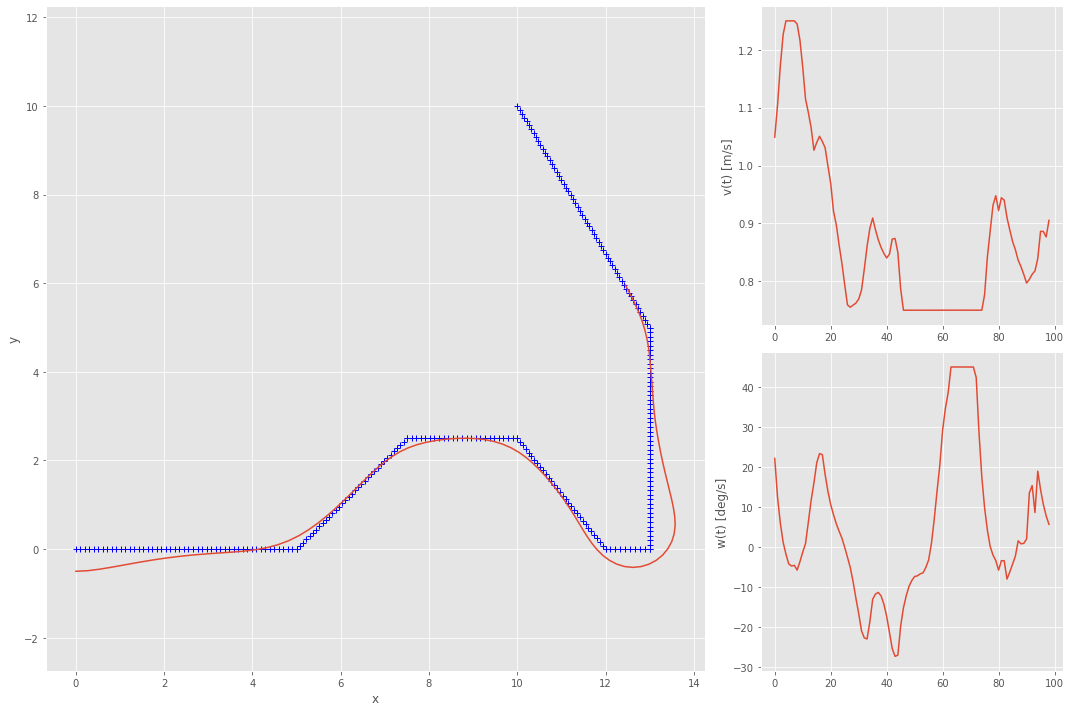

In [20]:
#plot trajectory
grid = plt.GridSpec(2, 3)

plt.figure(figsize=(15,10))

plt.subplot(grid[0:2, 0:2])
plt.plot(track[0,:],track[1,:],"b+")
plt.plot(x_sim[0,:],x_sim[1,:])
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(grid[0, 2])
plt.plot(u_sim[0,:])
plt.ylabel('v(t) [m/s]')

plt.subplot(grid[1, 2])
plt.plot(np.degrees(u_sim[1,:]))
plt.ylabel('w(t) [deg/s]')

plt.tight_layout()
plt.show()